In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from data_prep import DataPrep
from data_binning import *
from gsm_data import GSMData, get_desired_frequencies

## Upload Data

In [4]:
# Calibration type:
#'GSM' for antenna power - short power, 'raw' for antenna power
instrument = '100MHz'
channel = 'EW'
year = '2021'

In [66]:
path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'
calib_type = 'GSM'

with open(path2file + 'data' + file_ending, 'rb') as f:
    raw_data = np.load(f)
with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)
with open(path2file + 'short' + file_ending, 'rb') as f:
    short = np.load(f)
with open(path2file + 'res50' + file_ending, 'rb') as f:
    res50 = np.load(f)
# with open(path2file + 'res100' + file_ending, 'rb') as f:
#     res100 = np.load(f)

In [192]:
data = (raw_data - short) / (res50 - short)

In [9]:
freq_raw = np.linspace(0, 250, 4096)
day_splits = split_days(lst)

### Raw Data visualization

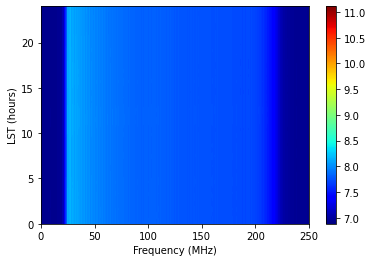

In [76]:
i = 2
tstart = day_splits[i]
tstop = day_splits[i+1]

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(np.linspace(0,250,4096), lst[tstart:tstop], 
               np.log10(short[tstart:tstop]), shading='nearest', cmap='jet')
plt.colorbar()
# plt.savefig('plots/raw_data_shortsub_100EW_day2.png', dpi=300)
plt.show()

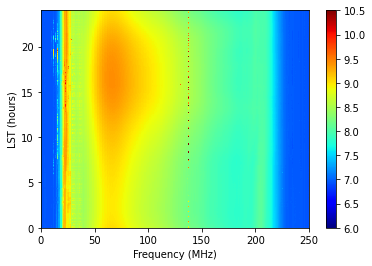

In [8]:
i = 2
tstart = day_splits[i]
tstop = day_splits[i+1]

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(np.linspace(0,250,4096), lst[tstart:tstop], 
               np.log10(raw_data[tstart:tstop]), shading='nearest', cmap='jet', vmin=6, vmax=10.5)
plt.colorbar()
# plt.savefig('plots/raw_data_shortsub_100EW_day2.png', dpi=300)
plt.show()

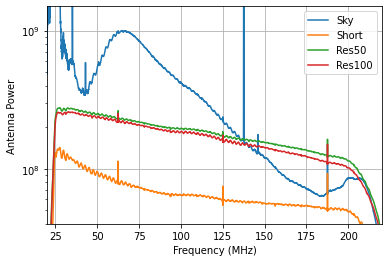

In [9]:
t = 61078
plt.xlabel('Frequency (MHz)')
plt.ylabel('Antenna Power')
plt.grid()
plt.yscale('log')
plt.ylim(4e7, 1.5e9)
plt.xlim(20,220)
plt.plot(np.linspace(0,250,4096), raw_data[t], label='Sky')
plt.plot(np.linspace(0,250,4096), short[t],label='Short')
plt.plot(np.linspace(0,250,4096), res50[t], label='Res50')
plt.plot(np.linspace(0,250,4096), res100[t], label='Res100')
plt.legend()

### 1. Truncate

#### Determine

In [20]:
binsize = 60
lst_binned60, data_binned60, bin_inds60 = lst_binning(data, lst, binsize, method='median')
data_binned60 = median_filter(data_binned60, size=(1,8))

In [21]:
MAD = np.array([np.nanmedian(np.abs(data_binned60[i] - data[bin_inds60==i]), \
                                           axis=0) for i in range(len(lst_binned60))])

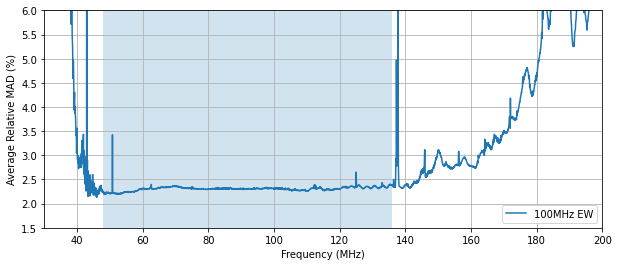

In [227]:
t = 20
plt.figure(figsize=(10,4))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Average Relative MAD (%)')
plt.grid()
plt.xlim(30,200)
plt.ylim(1.5, 6)
plt.axvspan(48, 136, alpha=0.2)
plt.plot(freq_raw, 100 * np.nanmean([MAD[t]/data_binned60[t] for t in range(len(lst_binned60))], axis=0), \
         label='100MHz EW', alpha=1)
plt.legend()

#### Truncate

In [10]:
def truncate(data, freq, highpass, lowpass):
    data = data[:, (freq >= highpass) & (freq < lowpass)]
    freq = freq[(freq >= highpass) & (freq < lowpass)]
    return data, freq

In [194]:
highpass= 48
lowpass= 136
rfi, rfi_freq = truncate(data, np.linspace(0,250, 4096), highpass, lowpass)

### 2. Flag by deviation from LST binned

In [73]:
def rfi_remove_lst(data, binsize, threshold):
    lst_binned, data_binned, bin_inds = lst_binning(data, lst, binsize, method='median')
    MAD = np.array([np.median(np.abs(data_binned[i] - data[bin_inds==i]), \
                                               axis=0) for i in range(len(lst_binned))])
    MAD = median_filter(MAD, size=100)
    x = (np.abs(data - data_binned[bin_inds]) > threshold *  MAD[bin_inds])
    data[x] = np.nan
    return data

In [195]:
binsize = 10
threshold = 8
t1 = time.time()
rfi_lst = rfi_remove_lst(np.copy(rfi), binsize, threshold)
time.time() - t1

40.82529044151306

In [196]:
def discard_bad_spectra(data, thresh):
    flag_rate_per_spec = np.sum(np.isnan(data), axis=1)/data.shape[1]
    data[flag_rate_per_spec > thresh, :] = np.nan
    return data

rfi_lst_spec = discard_bad_spectra(np.copy(rfi_lst), 0.1)

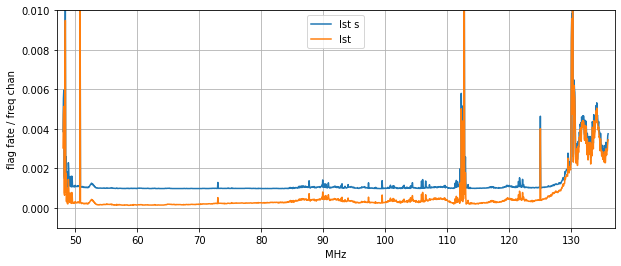

In [75]:
plt.figure(figsize=(10,4))
plt.grid()
plt.ylabel('flag fate / freq chan')
plt.xlabel('MHz')
plt.xlim(highpass-1, lowpass+1)
plt.ylim(-1e-3, 0.01)
plt.plot(rfi_freq, np.sum(np.isnan(rfi_lst_spec), axis=0)/rfi_lst.shape[0], label='lst s')
plt.plot(rfi_freq, np.sum(np.isnan(rfi_lst), axis=0)/rfi_lst.shape[0], label='lst')

plt.legend()

### 3. Flag in time stream

In [131]:
def tstream(data, w=10):
    # splits data into chunks so large time jumps don't screw up median filter
    breaks = np.where(np.abs(np.diff(lst)) % 23.5 > 1)[0]
    breaks = np.delete(breaks, np.where(np.diff(breaks) == 1)[0]) + 1
    breaks = np.insert(breaks, 0, 0)
    breaks = np.append(breaks, len(lst))

    filt_inds = np.zeros(len(lst), dtype=int)
    bin0 = -1

    med_filts = []
    # bin each chunk of data
    for b in range(len(breaks)-1):
        splits = range(breaks[b], breaks[b+1], w)

        temp = np.nanmedian([data[splits[i]:splits[i+1]] for i in range(len(splits)-1)], axis=1)
        med_filts.append(np.vstack([np.nanmedian(data[splits[-1]:breaks[b+1]], axis=0), temp]))

        filt_inds[breaks[b]:breaks[b+1]] = np.digitize(range(breaks[b], breaks[b+1]), splits) + bin0
        bin0 = filt_inds[breaks[b+1]-1]
    med_filt = np.vstack(med_filts)
    # thresh > 3sigma*2
    thresh = np.nanquantile(np.abs(data - med_filt[filt_inds]), 0.997, axis=0)
    # flag if abs deviation > thresh
    data[np.abs(data - med_filt[filt_inds]) > thresh*2] = np.nan
    return data

In [206]:
rfi_lststd_ts = tstream(np.copy(rfi_lst_std))

In [207]:
rfi_lststdts_s_calib = discard_bad_spectra(np.copy(rfi_lststd_ts), 0.1)

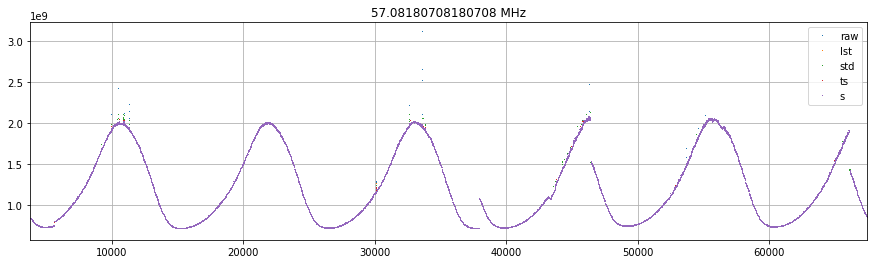

In [145]:
f = 148
i = 1
plt.figure(figsize=(15,4))
plt.title(f'{rfi_freq[f]} MHz')
plt.grid()
plt.xlim(day_splits[i], day_splits[i+7])
plt.plot(rfi[:, f], ',', label='raw')
plt.plot(rfi_lst[:, f], ',', label='lst')
plt.plot(rfi_lst_std[:, f-4], ',', label='std')
plt.plot(rfi_lststd_ts[:, f-4], ',', label='ts')
plt.plot(rfi_lststdts_s[:, f-4], ',', label='s')
plt.legend()

### 4. std flag freq space

### freq std optimal thresh/window

#### Determine threshold

noise for non flagged

In [16]:
binsize = 60
binsize /= 60
bins = np.arange(binsize / 2, 24 + binsize / 2, binsize)
bin_inds = np.digitize(lst, bins=(bins + binsize / 2))

noise = [np.nanstd(rfi[bin_inds == i], axis=0) for i in range(len(bins))]

break down of function (TODO optimize efficiency, currently ~5 min)

In [408]:
window = 8

t1 = time.time()
h = window // 2
N = rfi.shape[1]

x = np.array([np.copy(rfi)[:, i - h:i + (h+1)] for i in range(h, N - h)])
x_flag = np.delete(x, h, axis=-1)
time.time() - t1

22.32911467552185

In [409]:
t1 = time.time()
std = np.nanstd(x, axis=-1)
flag_std = np.nanstd(x_flag, axis=-1)
time.time() - t1

91.8948655128479

In [410]:
t1 = time.time()
res = np.transpose((std - flag_std) / np.nanmedian(x, axis=-1))
time.time() - t1

142.0614972114563

flag on thresh grid

In [ ]:
threshs = np.logspace(1, -6, num=15)

flag_rate = []
noise_means = []
rfi_stds = []

for thresh in threshs:
    flag_inds = np.where(res > thresh)
    temp = np.copy(rfi)[:, h : N - h]
    temp[flag_inds] = np.nan
    
    rfi_stds.append(temp)
    noise_flagged = [np.nanstd(temp[bin_inds == i], axis=0) for i in range(len(bins))]
    noise_means.append(np.nanmean(noise_flagged / np.array(noise)[:, 4:-4]))
    flag_rate.append(np.nansum(np.isnan(temp))/temp.shape[0]/temp.shape[1])

noise flagged (thresh grid)

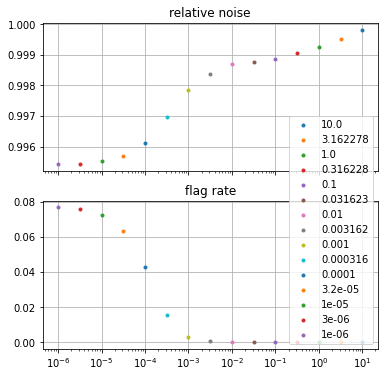

In [433]:
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots(2, 1, sharex=True)
ax[0].set_title('relative noise')
ax[1].set_title('flag rate')
for n, i in enumerate([noise_means, flag_rate]):
    ax[n].set_xscale('log')
    ax[n].grid()
    for m, t in enumerate(threshs):
        ax[n].plot(t, i[m], '.', label=round(t, 6))
ax[1].legend(loc=4)

want to minimize flag rate, maximize drop in noise

optimal thresh = 0.001

#### Determine optimal window

In [267]:
rfi_std_10 = flag_freq_std(np.copy(rfi), 10, 0.001, 1)

In [251]:
rfi_std_4 = flag_freq_std(np.copy(rfi), 4, 0.001, 1)
rfi_std_12 = flag_freq_std(np.copy(rfi), 12, 0.001, 1)
rfi_std_16 = flag_freq_std(np.copy(rfi), 16, 0.001, 1)

In [268]:
noise_flagged_wind = [np.nanstd(rfi_std_10[bin_inds == i], axis=0) for i in range(len(bins))]
noise_means_wind.append(np.nanmean(noise_flagged_wind / np.array(noise)[:, 5:-5]))
flag_rate_wind.append(np.nansum(np.isnan(rfi_std_10))/np.prod(rfi_std_10.shape))

In [269]:
winds = [4, 8, 12, 16, 10]

In [262]:
winds = [4, 8, 12, 16, 10]
noise_means_wind = []
flag_rate_wind = []
for n, d in enumerate([rfi_std_4, rfi_std, rfi_std_12, rfi_std_16, rfi_std_10]):
    noise_flagged_wind = [np.nanstd(d[bin_inds == i], axis=0) for i in range(len(bins))]
    noise_means_wind.append(np.nanmean(noise_flagged_wind / np.array(noise)[:, winds[n]//2:-winds[n]//2]))
    flag_rate_wind.append(np.nansum(np.isnan(d))/np.prod(d.shape))

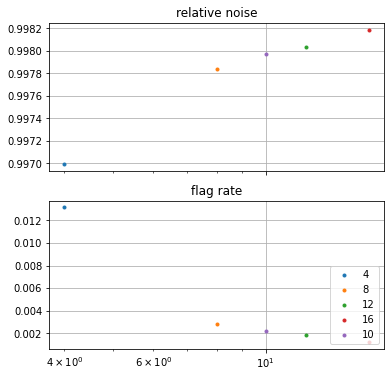

In [270]:
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots(2, 1, sharex=True)
ax[0].set_title('relative noise')
ax[1].set_title('flag rate')
for n, i in enumerate([noise_means_wind, flag_rate_wind]):
    ax[n].set_xscale('log')
    ax[n].grid()
    for m, w in enumerate(winds):
        ax[n].plot(w, i[m], '.', label=w)
ax[1].legend(loc=4)

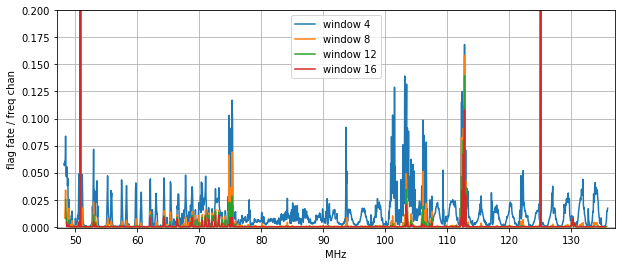

In [272]:
plt.figure(figsize=(10,4))
plt.grid()
plt.ylabel('flag fate / freq chan')
plt.xlabel('MHz')
plt.xlim(highpass-1, lowpass+1)
plt.ylim(-1e-3, 0.2)
plt.plot(rfi_freq[2:-2], np.sum(np.isnan(rfi_std_4), axis=0)/rfi_std_4.shape[0], label='window 4')
plt.plot(rfi_freq[4:-4], np.sum(np.isnan(rfi_std), axis=0)/rfi_std.shape[0], label='window 8')
plt.plot(rfi_freq[6:-6], np.sum(np.isnan(rfi_std_12), axis=0)/rfi_std_12.shape[0], label='window 12')
plt.plot(rfi_freq[8:-8], np.sum(np.isnan(rfi_std_16), axis=0)/rfi_std_16.shape[0], label='window 16')
plt.legend()

#### optimal thresh for pass2

In [14]:
window = 8
dat = np.copy(rfi_std)
h = window // 2
N = dat.shape[1]

x2 = np.array([dat[:, i - h:i + (h+1)] for i in range(h, N - h)])
x_flag2 = np.delete(x2, h, axis=-1)

std2 = np.nanstd(x2, axis=-1)
flag_std2 = np.nanstd(x_flag2, axis=-1)

res2 = np.transpose((std2 - flag_std2) / np.nanmedian(x2, axis=-1))

In [15]:
threshs = np.logspace(1, -6, num=15)

flag_rate2 = []
noise_means2 = []
rfi_stds2 = []

for thresh in threshs:
    flag_inds = np.where(res2 > thresh)
    temp = np.copy(rfi_std)[:, h : N - h]
    temp[flag_inds] = np.nan
    
    rfi_stds2.append(temp)
    noise_flagged = [np.nanstd(temp[bin_inds == i], axis=0) for i in range(len(bins))]
    noise_means2.append(np.nanmean(noise_flagged / np.array(noise)[:, 8:-8]))
    flag_rate2.append(np.nansum(np.isnan(temp))/temp.shape[0]/temp.shape[1])

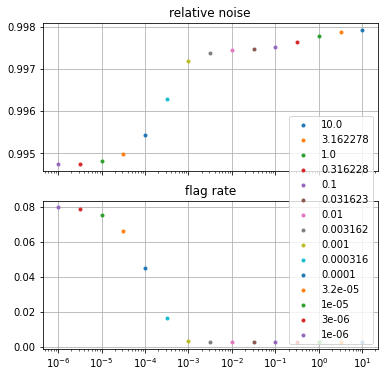

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots(2, 1, sharex=True)
ax[0].set_title('relative noise')
ax[1].set_title('flag rate')
# ax[0].hlines(noise_means[8], xmin=threshs[0], xmax=threshs[-1])
# ax[1].hlines(flag_rate[8], xmin=threshs[0], xmax=threshs[-1])
for n, i in enumerate([noise_means2, flag_rate2]):
    ax[n].set_xscale('log')
    ax[n].grid()
    for m, t in enumerate(threshs):
        ax[n].plot(t, i[m], '.', label=round(t, 6))
ax[1].legend(loc=4)

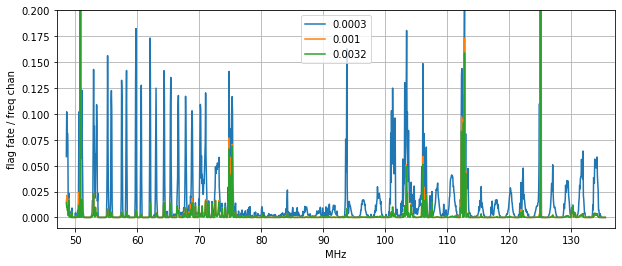

In [35]:
plt.figure(figsize=(10,4))
plt.grid()
plt.ylabel('flag fate / freq chan')
plt.xlabel('MHz')
plt.xlim(highpass-1, lowpass+1)
plt.ylim(-1e-2, 0.2)
for i in [9,8,7]:
    plt.plot(rfi_freq[8:-8], np.sum(np.isnan(rfi_stds2[i]), axis=0)/rfi_stds2[i].shape[0], label=f'{round(threshs[i], 4)}')
plt.legend()

#### Flag

In [177]:
def flag_freq_std(data, window, thresh, width):
    h = window // 2
    N = data.shape[1]
    
    x = np.array([data[:, i - h:i + (h+1)] for i in range(h, N - h)])
    med_filt = np.nanmedian(x, axis=-1)
    
    x -= med_filt[:,:,None]
    x_flag = np.delete(x, h, axis=-1)
    
    std = np.nanstd(x, axis=-1)
    flag_std = np.nanstd(x_flag, axis=-1)

    res = ((std - flag_std) / med_filt).T
    flag_inds = np.where(res > thresh)
    
    data = data[:, h : N - h]
    data[flag_inds] = np.nan
    return data

In [574]:
rfi_lstts_std = flag_freq_std(np.copy(rfi_lst_ts), 8, 0.001, 1)
rfi_lstts_std2 = flag_freq_std(np.copy(rfi_lstts_std), 8, 0.001, 1)

### 5. Discard freq & spectra

In [307]:
def discard_bad_freq(data, thresh):
    flag_rate_per_freq = np.sum(np.isnan(data), axis=0)/data.shape[0]
    data[:, flag_rate_per_freq > thresh] = np.nan
    return data

def discard_bad_spectra(data, thresh):
    flag_rate_per_spec = np.sum(np.isnan(data), axis=1)/data.shape[1]
    data[flag_rate_per_spec > thresh, :] = np.nan
    return data

In [576]:
rfi_lsttsstd2_s = discard_bad_spectra(np.copy(rfi_lstts_std2), 0.05)

In [577]:
rfi_lsttsstd2_sf = discard_bad_freq(np.copy(rfi_lstts_std2), 0.1)

In [588]:
np.save('rfi/100EW 2021/rfi_lstts_std_wind12_thresh1e-3.npy', rfi_lstts_std_12)
np.save('rfi/100EW 2021/rfi_lstts_std2_wind12_thresh1e-3.npy', rfi_lstts_std2_12)

In [579]:
print(f'Total flag percentage: {round(np.sum(np.isnan(rfi_lsttsstd2_sf)) / np.prod(rfi_lsttsstd2_sf.shape) * 100, 2)}%')

Total flag percentage: 0.73%


#### 5. Discard bad days/hours

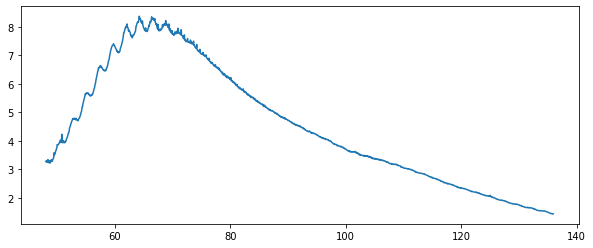

In [145]:
plt.figure(figsize=(10,4))
for t in range(47603, 47604):
    plt.plot(rfi_freq, rfi[t], label=f'{t}')
# plt.legend()

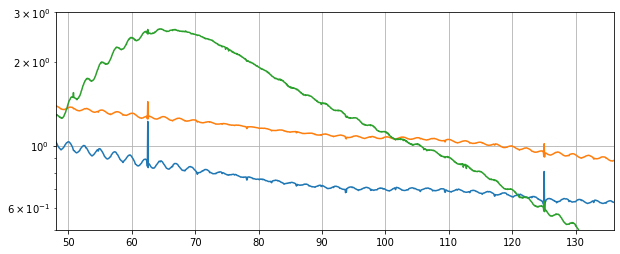

In [192]:
plt.figure(figsize=(10,4))
plt.grid()
plt.yscale('log')
plt.xlim(48,136)
plt.ylim(5e-1, 3e0)
for t in range(37569, 37570):
    plt.plot(freq_raw, short[t] / np.mean(short[t]), label='short')
    plt.plot(freq_raw, res50[t] / np.mean(res50[t]), label='res50')
    plt.plot(freq_raw, raw_data[t] / np.mean(raw_data[t]), label='sky')

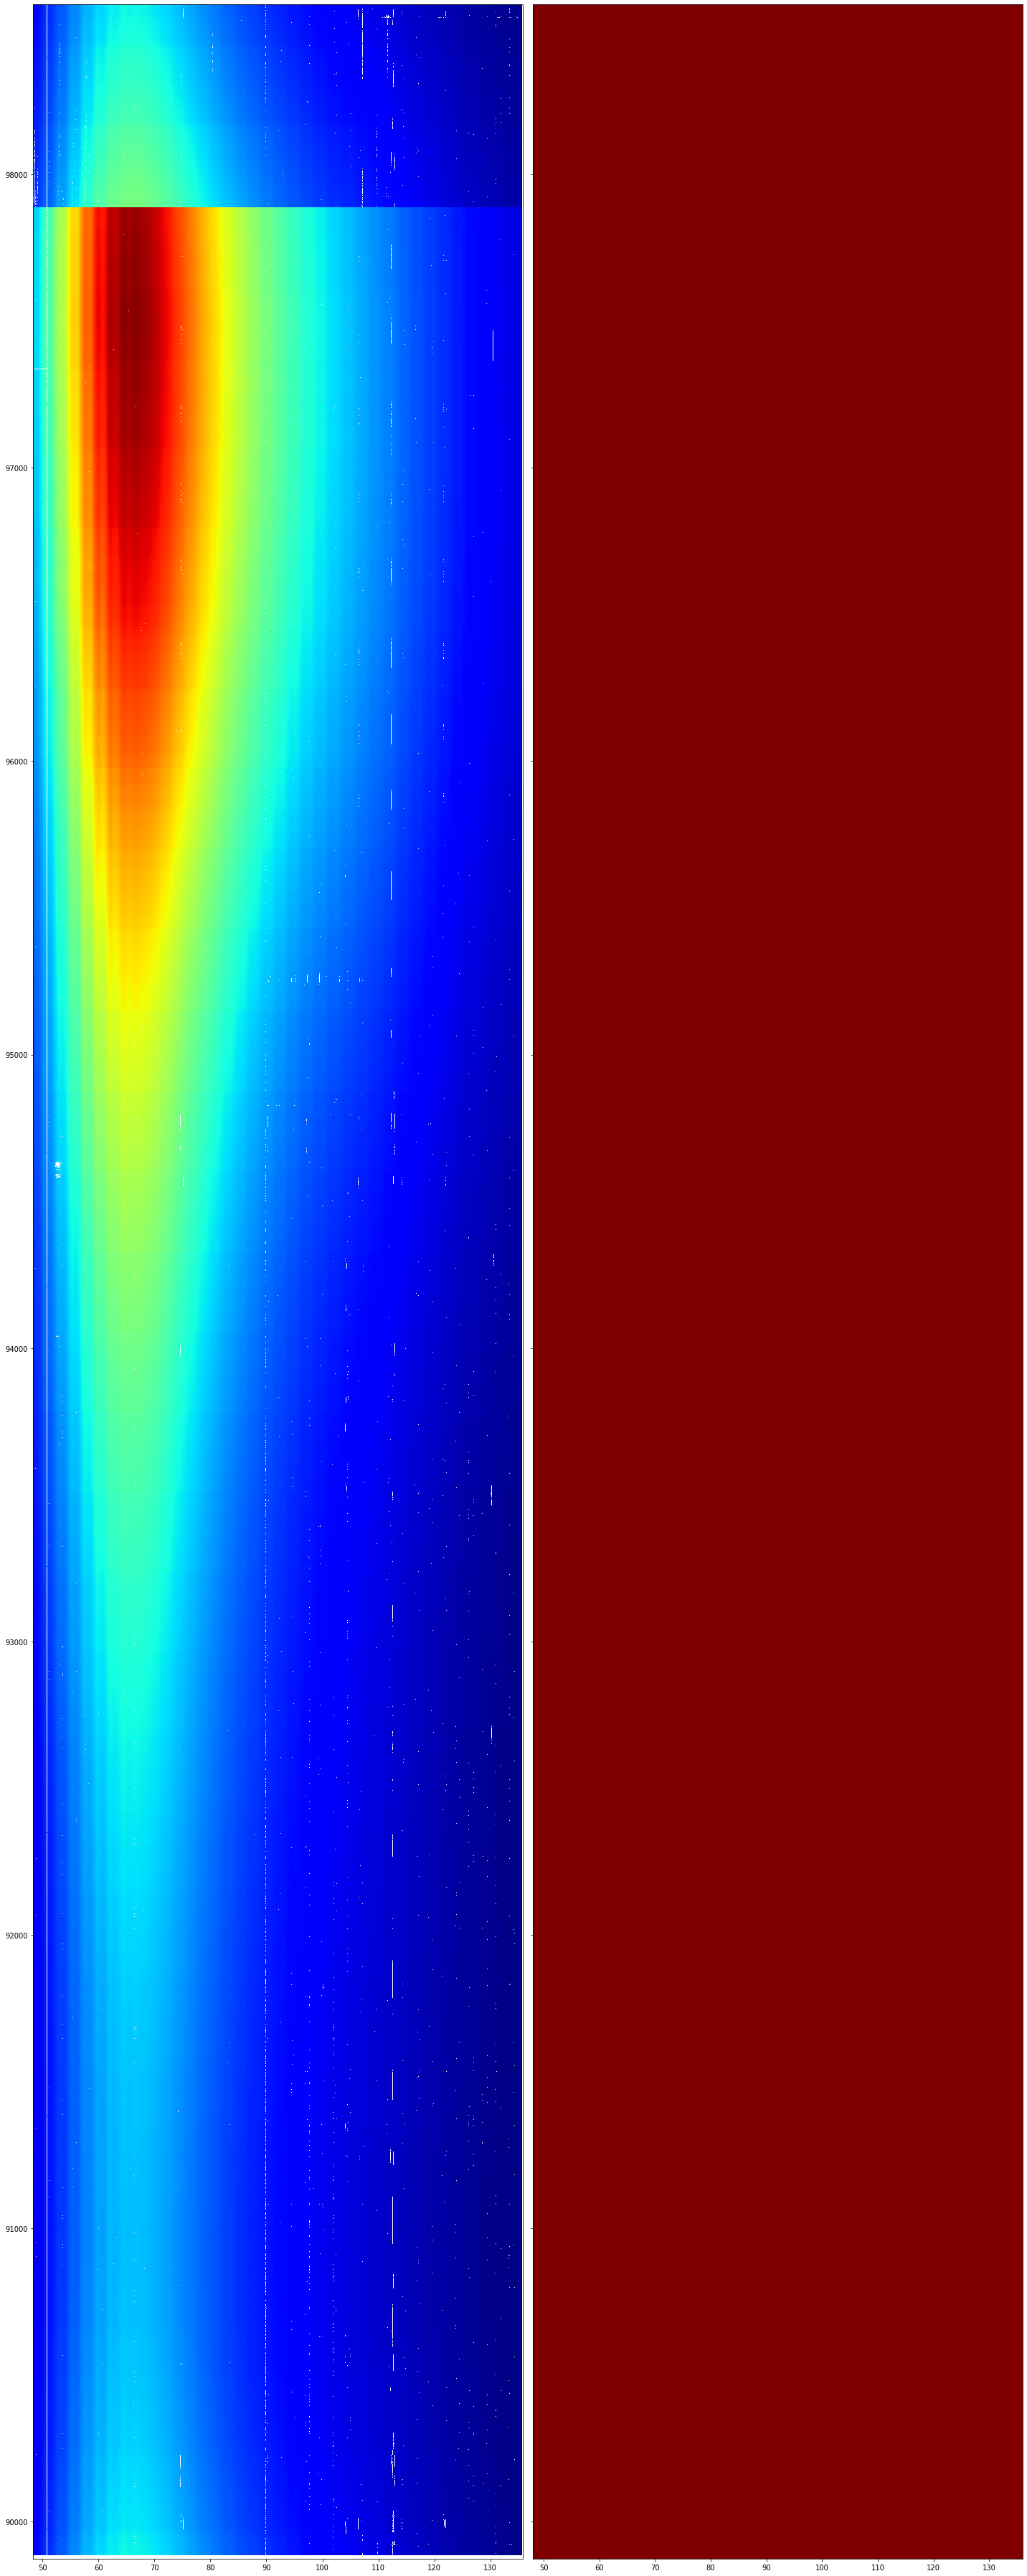

In [151]:
d = 10
tstart = day_splits[d]
tstop =  day_splits[d+1]
fstart = 0
fstop = -1

fig = plt.figure(figsize=(20,50))
ax = fig.subplots(1,2, sharey=True)
ax[0].pcolormesh(rfi_freq[4:-4], range(tstart, tstop), rfi_lststdts_s[tstart:tstop], shading='nearest', cmap='jet')
ax[1].pcolormesh(rfi_freq, range(tstart, tstop), rfi[tstart:tstop], shading='nearest', cmap='jet', vmin=1, vmax=18)
plt.tight_layout()
plt.show()